# Forecasting :
***Problem Statement :***
- Forecast the Airlines Passengers data set. 

In [50]:
# Importing usefull libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from datetime import datetime as dt
from IPython.display import display
from statsmodels.tsa.stattools import acf, pacf
from pandas.tseries.offsets import DateOffset

# Ignore anoying warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Loading Airline dataset
airline = pd.read_excel("Airlines+Data.xlsx", index_col=0, date_parser=True)

# Showing the loaded dataset
airline.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [6]:
# Dimensions of given dataset
airline.shape

(96, 1)

In [7]:
# Summary of dataset
airline.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 1995-01-01 to 2002-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  96 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB


In [9]:
# Looking for null values
airline.isna().any().any()

False

In [11]:
# Checking basic stats
airline.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,96.0,213.708333,71.918216,104.0,156.0,200.0,264.75,413.0


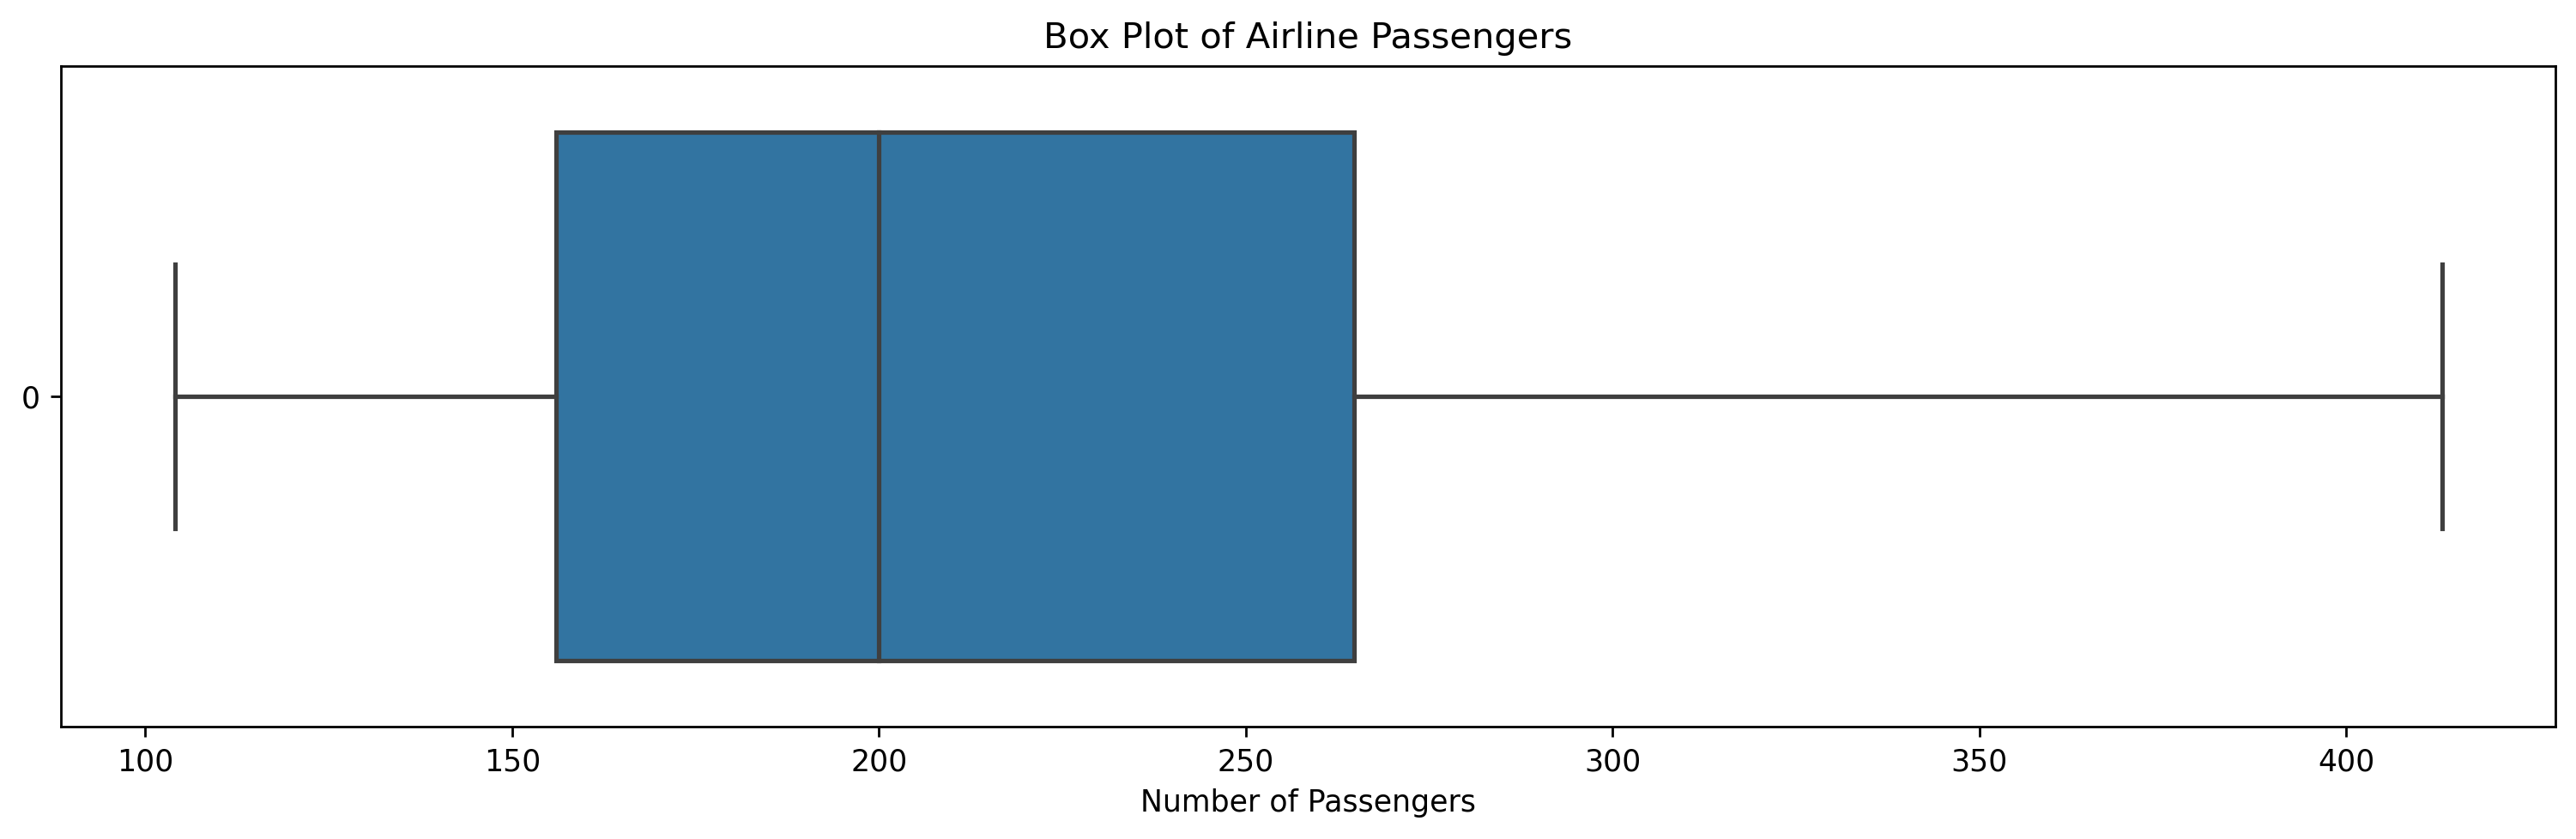

In [24]:
# Using box plot to visualize the outliers
plt.figure(figsize=(15,4),dpi=250)
sns.boxplot(airline["Passengers"], orient='h')
plt.xlabel("Number of Passengers")
plt.title("Box Plot of Airline Passengers")
plt.show()

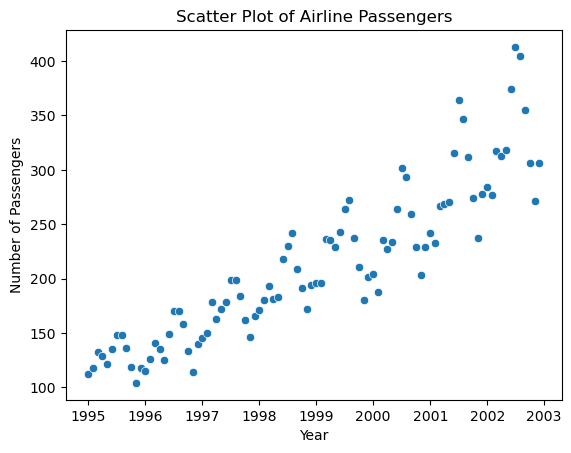

In [25]:
# Using scatter plot to visualize the outliers
sns.scatterplot(x=airline.index, y=airline["Passengers"])
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.title("Scatter Plot of Airline Passengers")
plt.show()

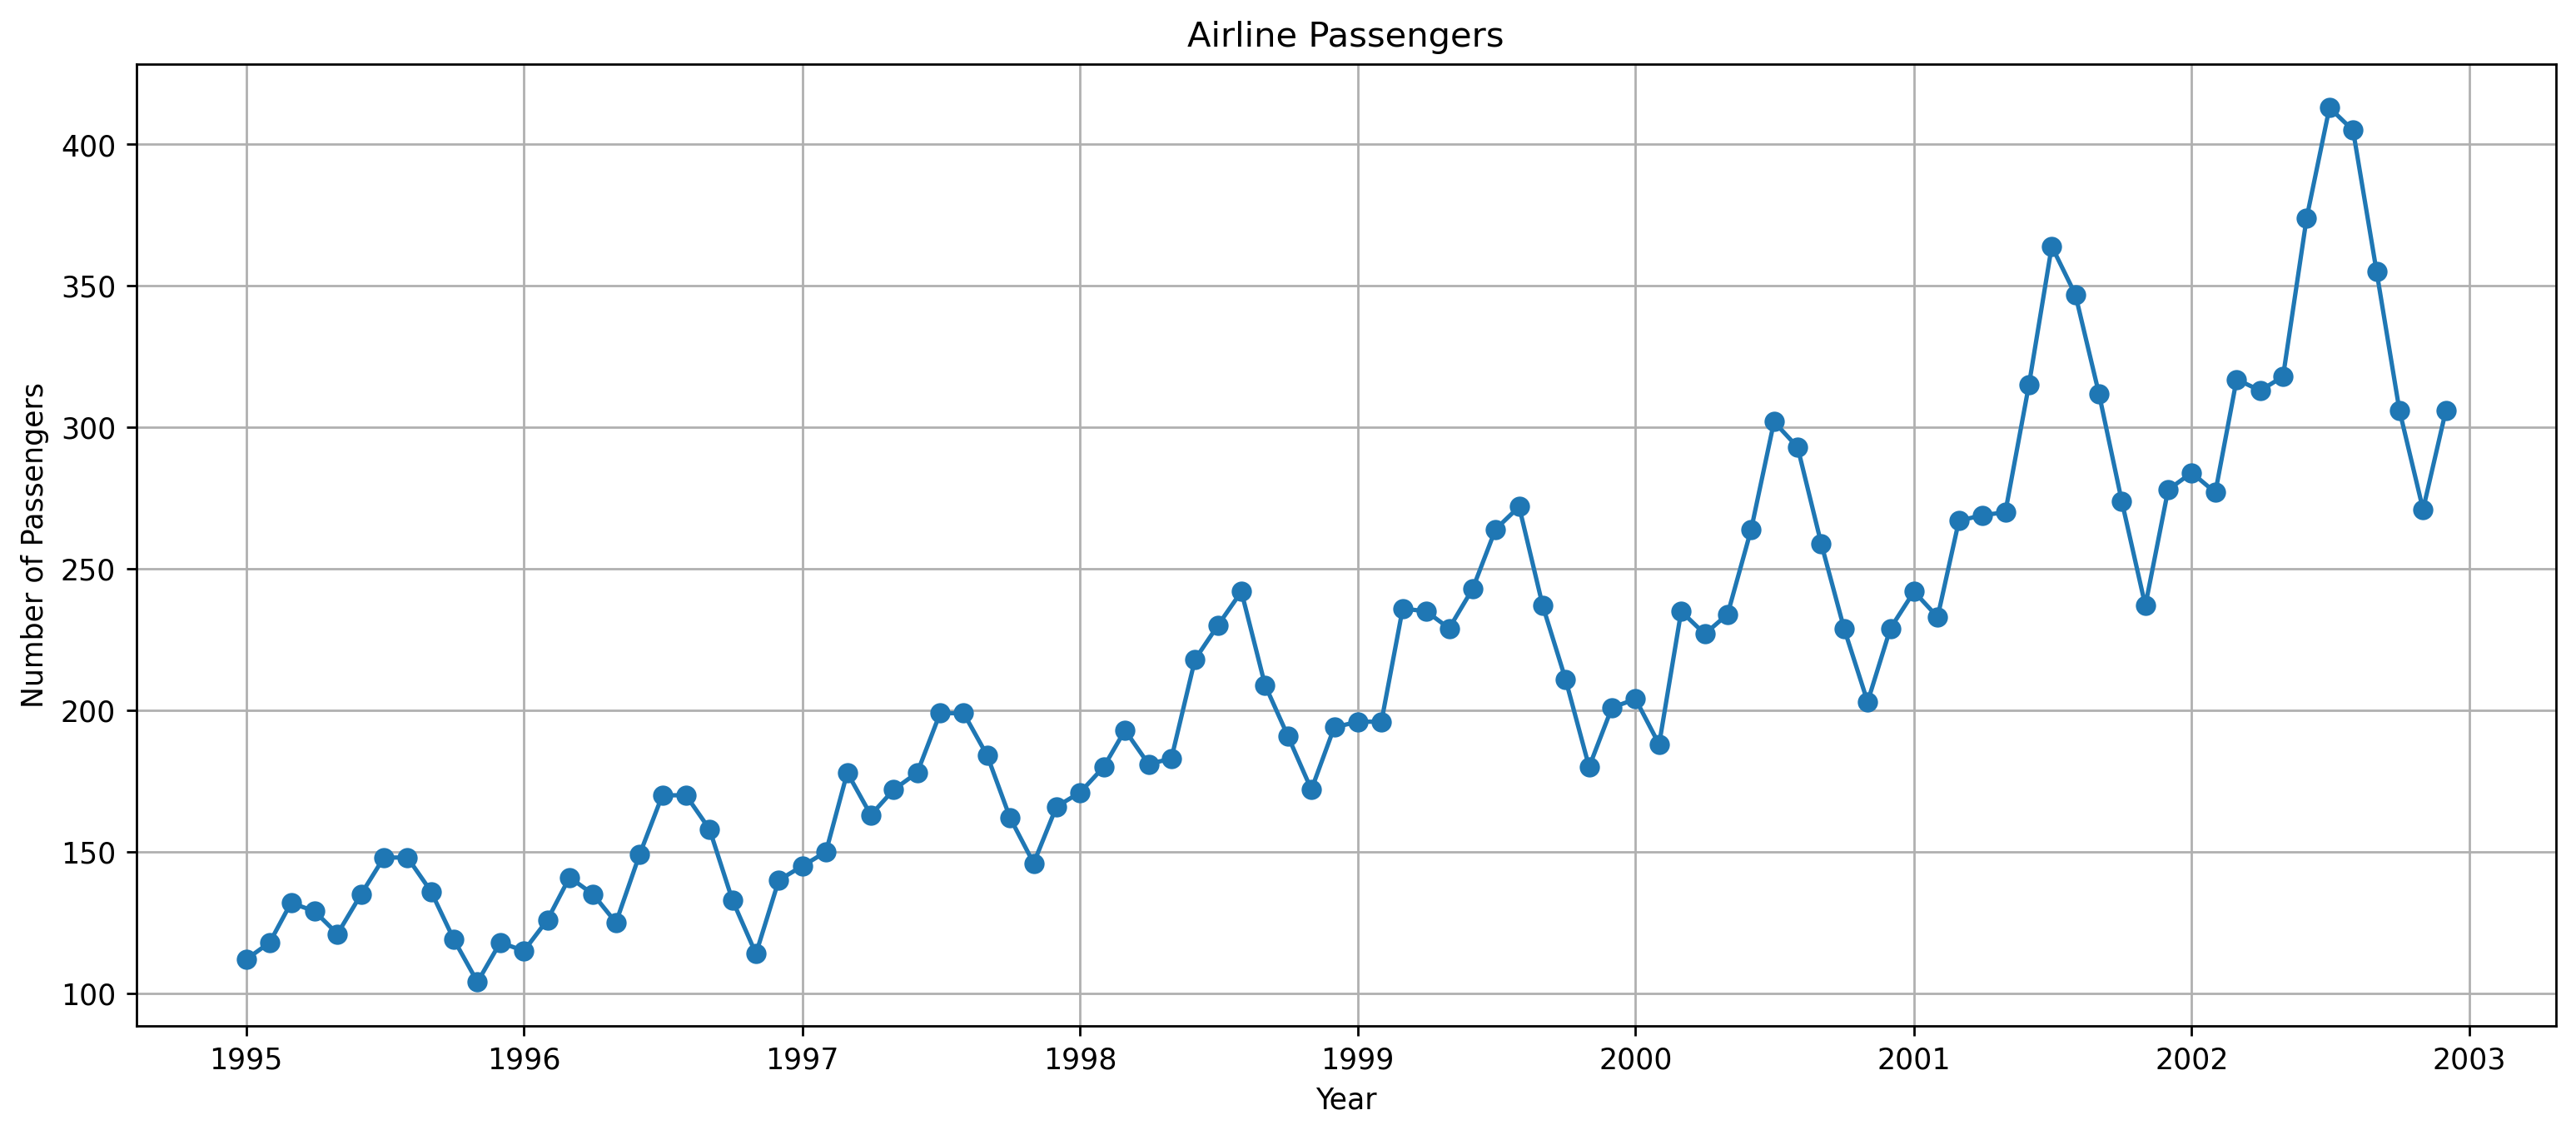

In [28]:
# Plotting the time series data
plt.figure(figsize=(15,6),dpi=250)
plt.plot(airline,marker='o')
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.title("Airline Passengers")
plt.grid()
plt.show()

**Stationarize the Series :**

In [39]:
plt.rcParams['figure.figsize'] = (15,5)
plt.rcParams['figure.dpi'] = 250

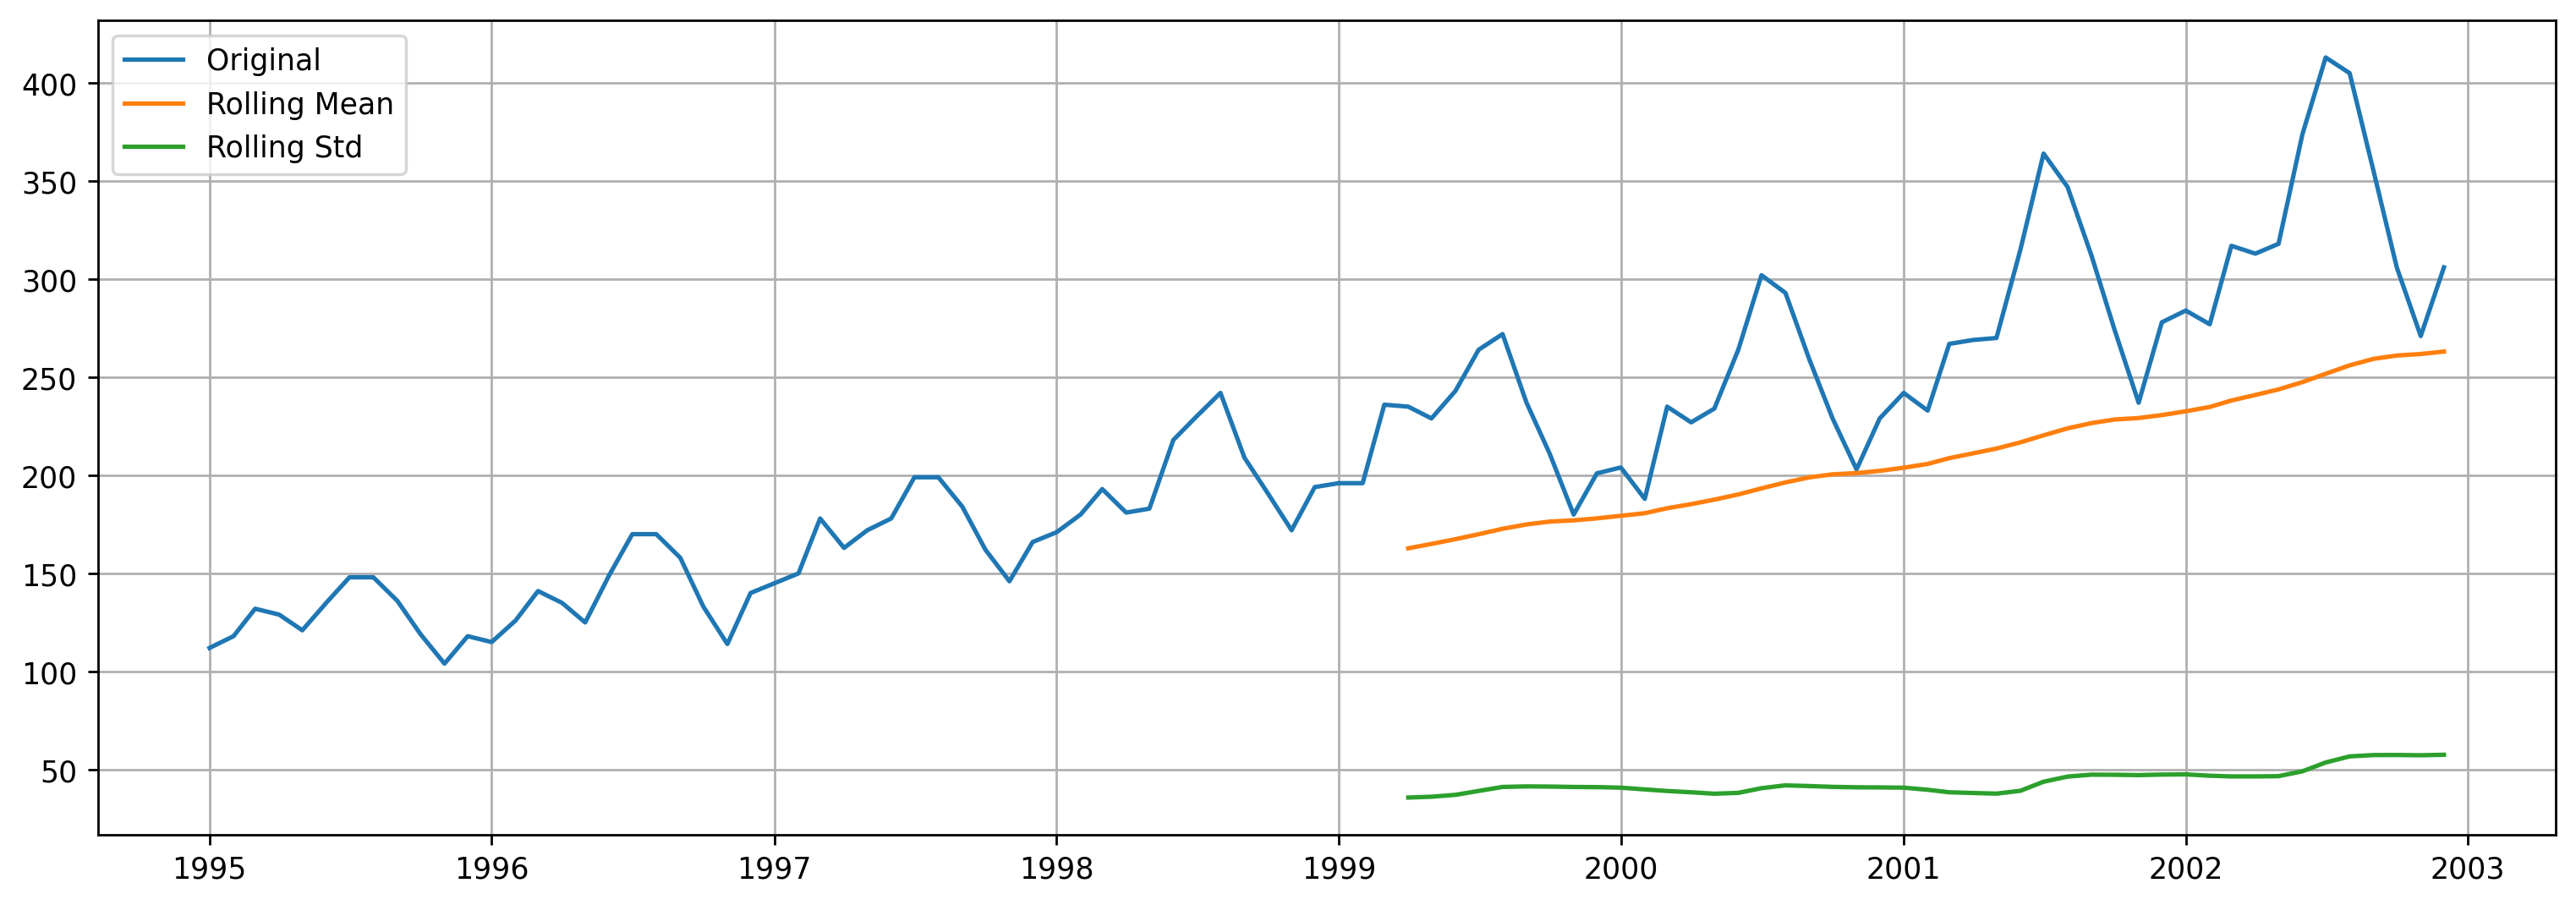

T Statistic            1.340248
P-Value                0.996825
#Lags Used            12.000000
#Observations Used    83.000000
Critical value 1%     -3.511712
Critical value 5%     -2.897048
Critical value 10%    -2.585713
dtype: float64


In [40]:
# Checking the stationarity of data

def Stationarity_Check(ts):
    plt.plot(ts, label='Original')
    plt.plot(ts.rolling(window=52, center=False).mean(), label='Rolling Mean')
    plt.plot(ts.rolling(window=52, center=False).std(), label='Rolling Std')
    plt.grid()
    plt.legend()
    plt.show()
    
    adf = adfuller(ts, autolag='AIC')
    padf = pd.Series(adf[:4], index=['T Statistic','P-Value','#Lags Used','#Observations Used'])
    for k,v in adf[4].items():
        padf['Critical value {}'.format(k)]=v
    print(padf)
    
Stationarity_Check(airline['Passengers'])

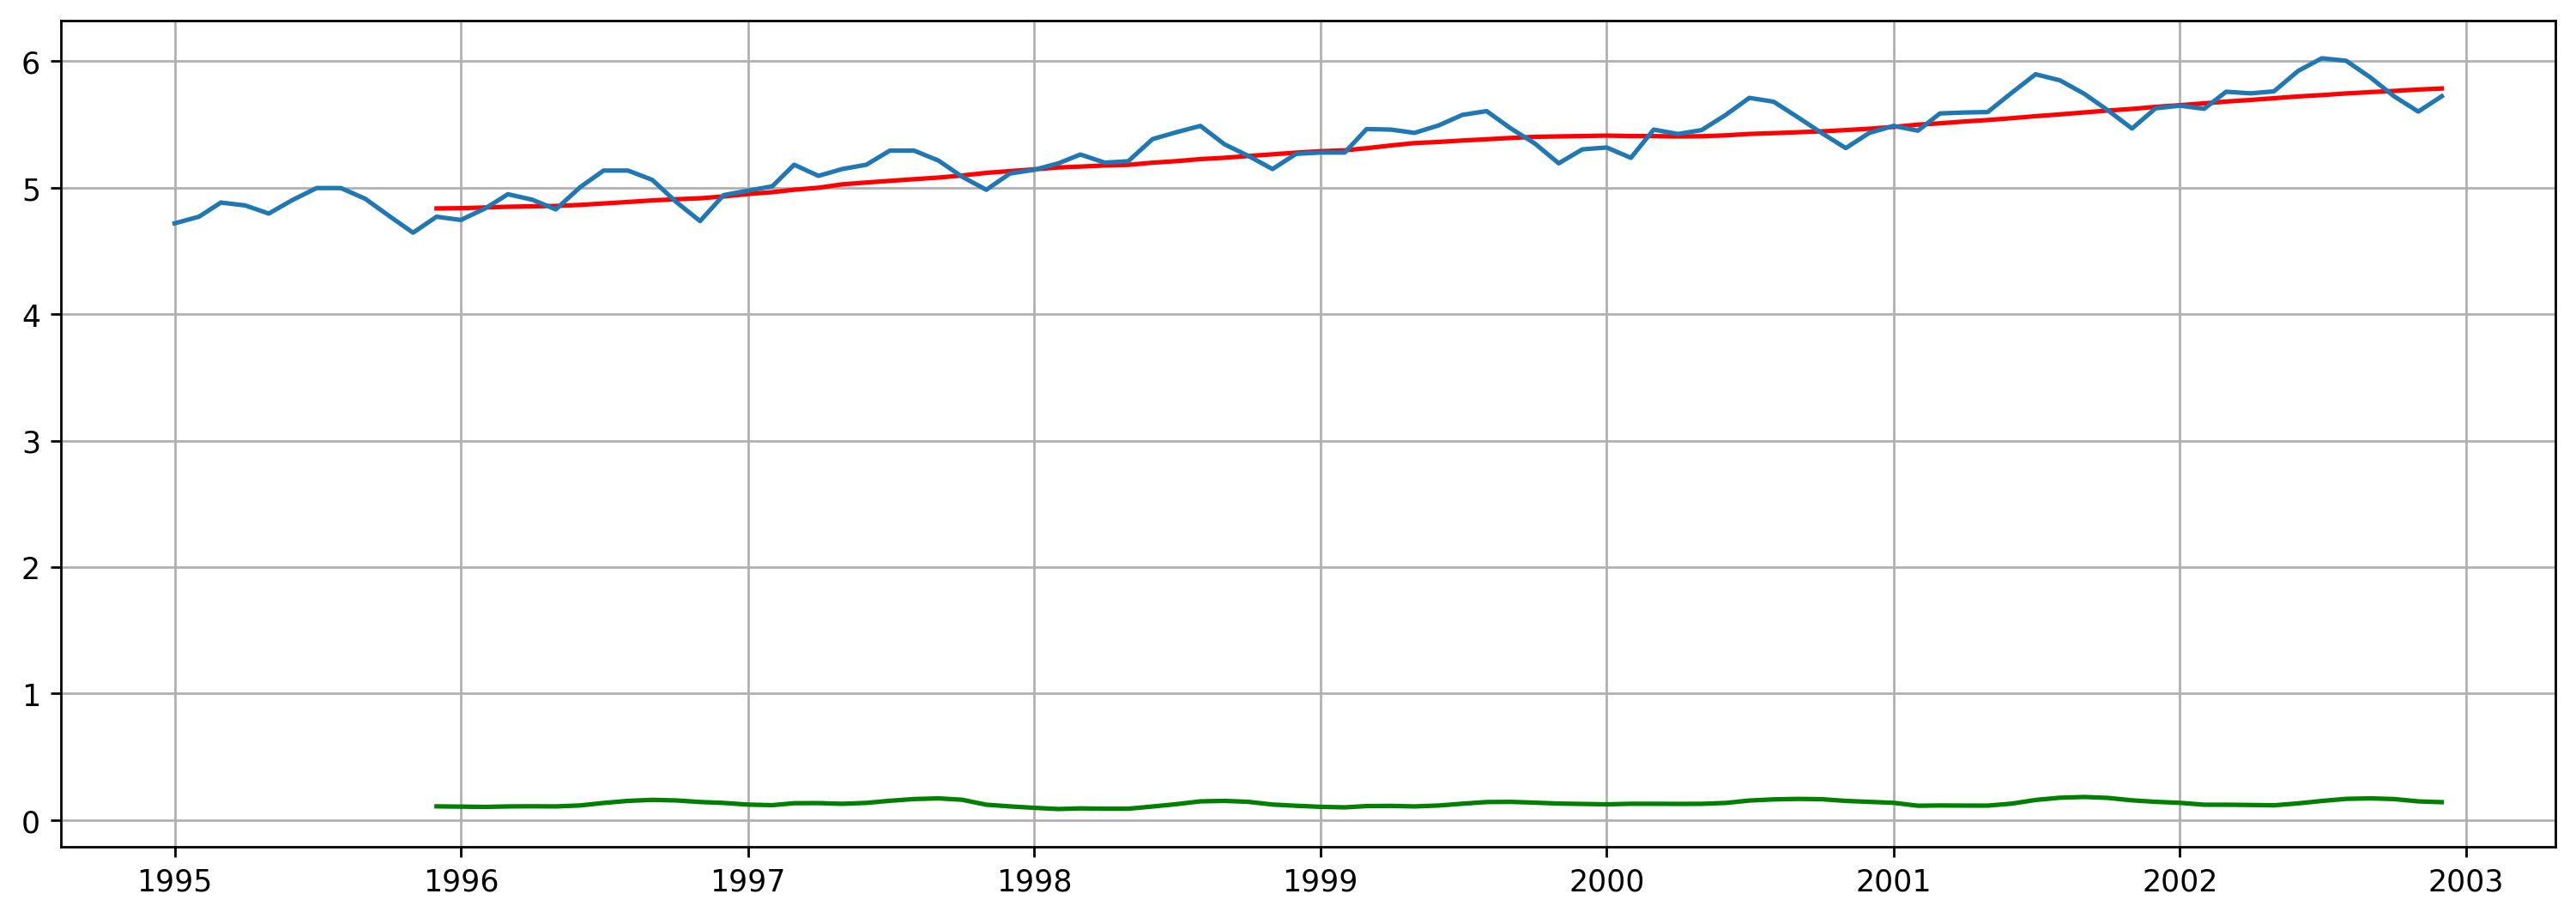

In [43]:
#Decomposing using moving average

tsl = np.log(airline)
ma = tsl.rolling(window=12).mean()
ms = tsl.rolling(window=12).std()

plt.plot(ma, c='r')#, center=False)
plt.plot(ms, c='g')
plt.plot(tsl)
plt.grid()
plt.show()

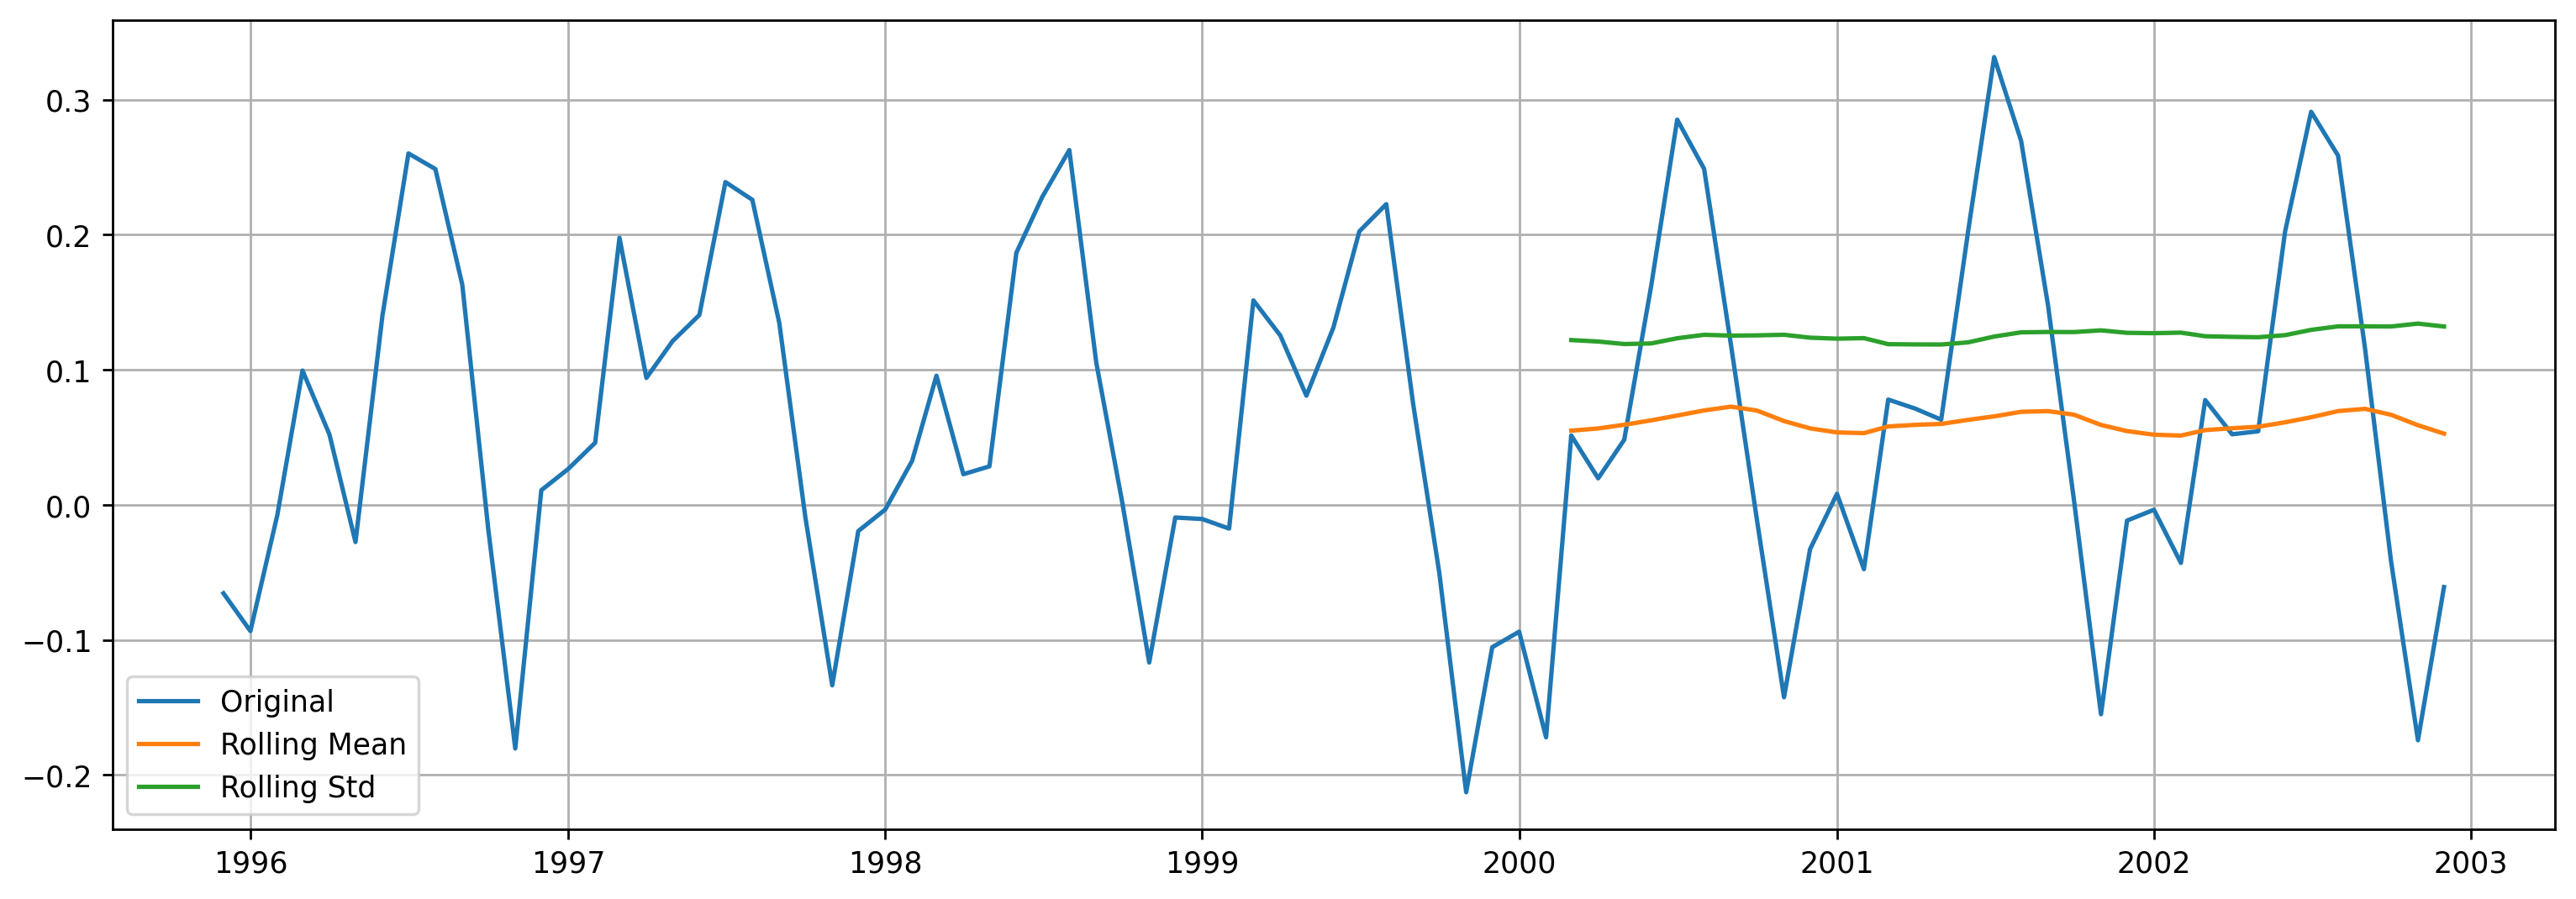

T Statistic           -1.910930
P-Value                0.326937
#Lags Used            12.000000
#Observations Used    72.000000
Critical value 1%     -3.524624
Critical value 5%     -2.902607
Critical value 10%    -2.588679
dtype: float64


In [44]:
# Stationarity Check for Decomposed Time Series

tsl - np.log(airline)
ma = tsl.rolling(window=12, center=False).mean()

tslma = tsl - ma
tslma = tslma.dropna()
Stationarity_Check(tslma)

**Plotting ACF & PACF :**

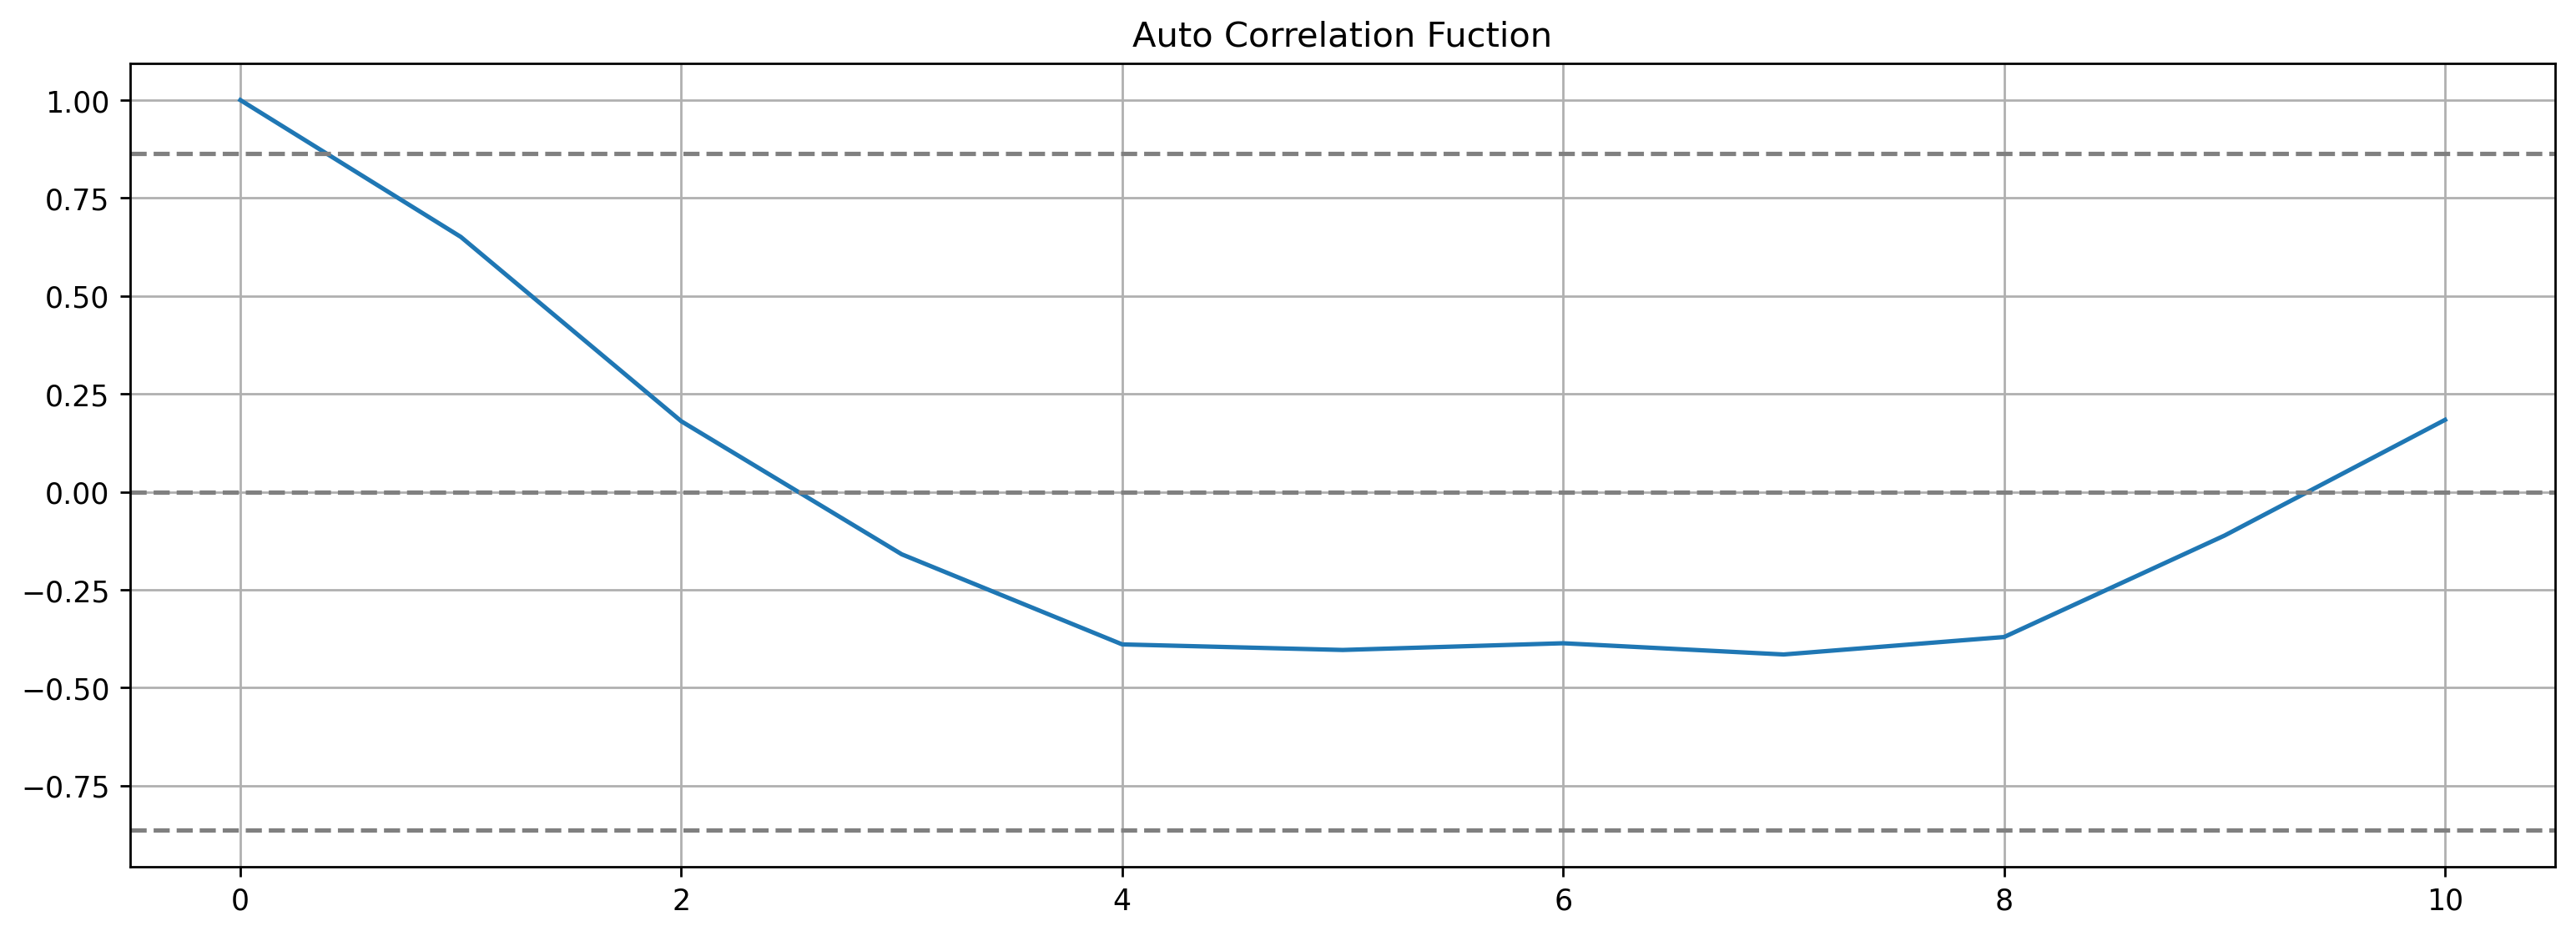

In [46]:
# Auto Correlation Fuction (ACF)

plt.plot(np.arange(acf(tslma, nlags=10,fft=True).shape[0]),acf(tslma, nlags=10, fft=True))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.title('Auto Correlation Fuction')
plt.grid()
plt.show()

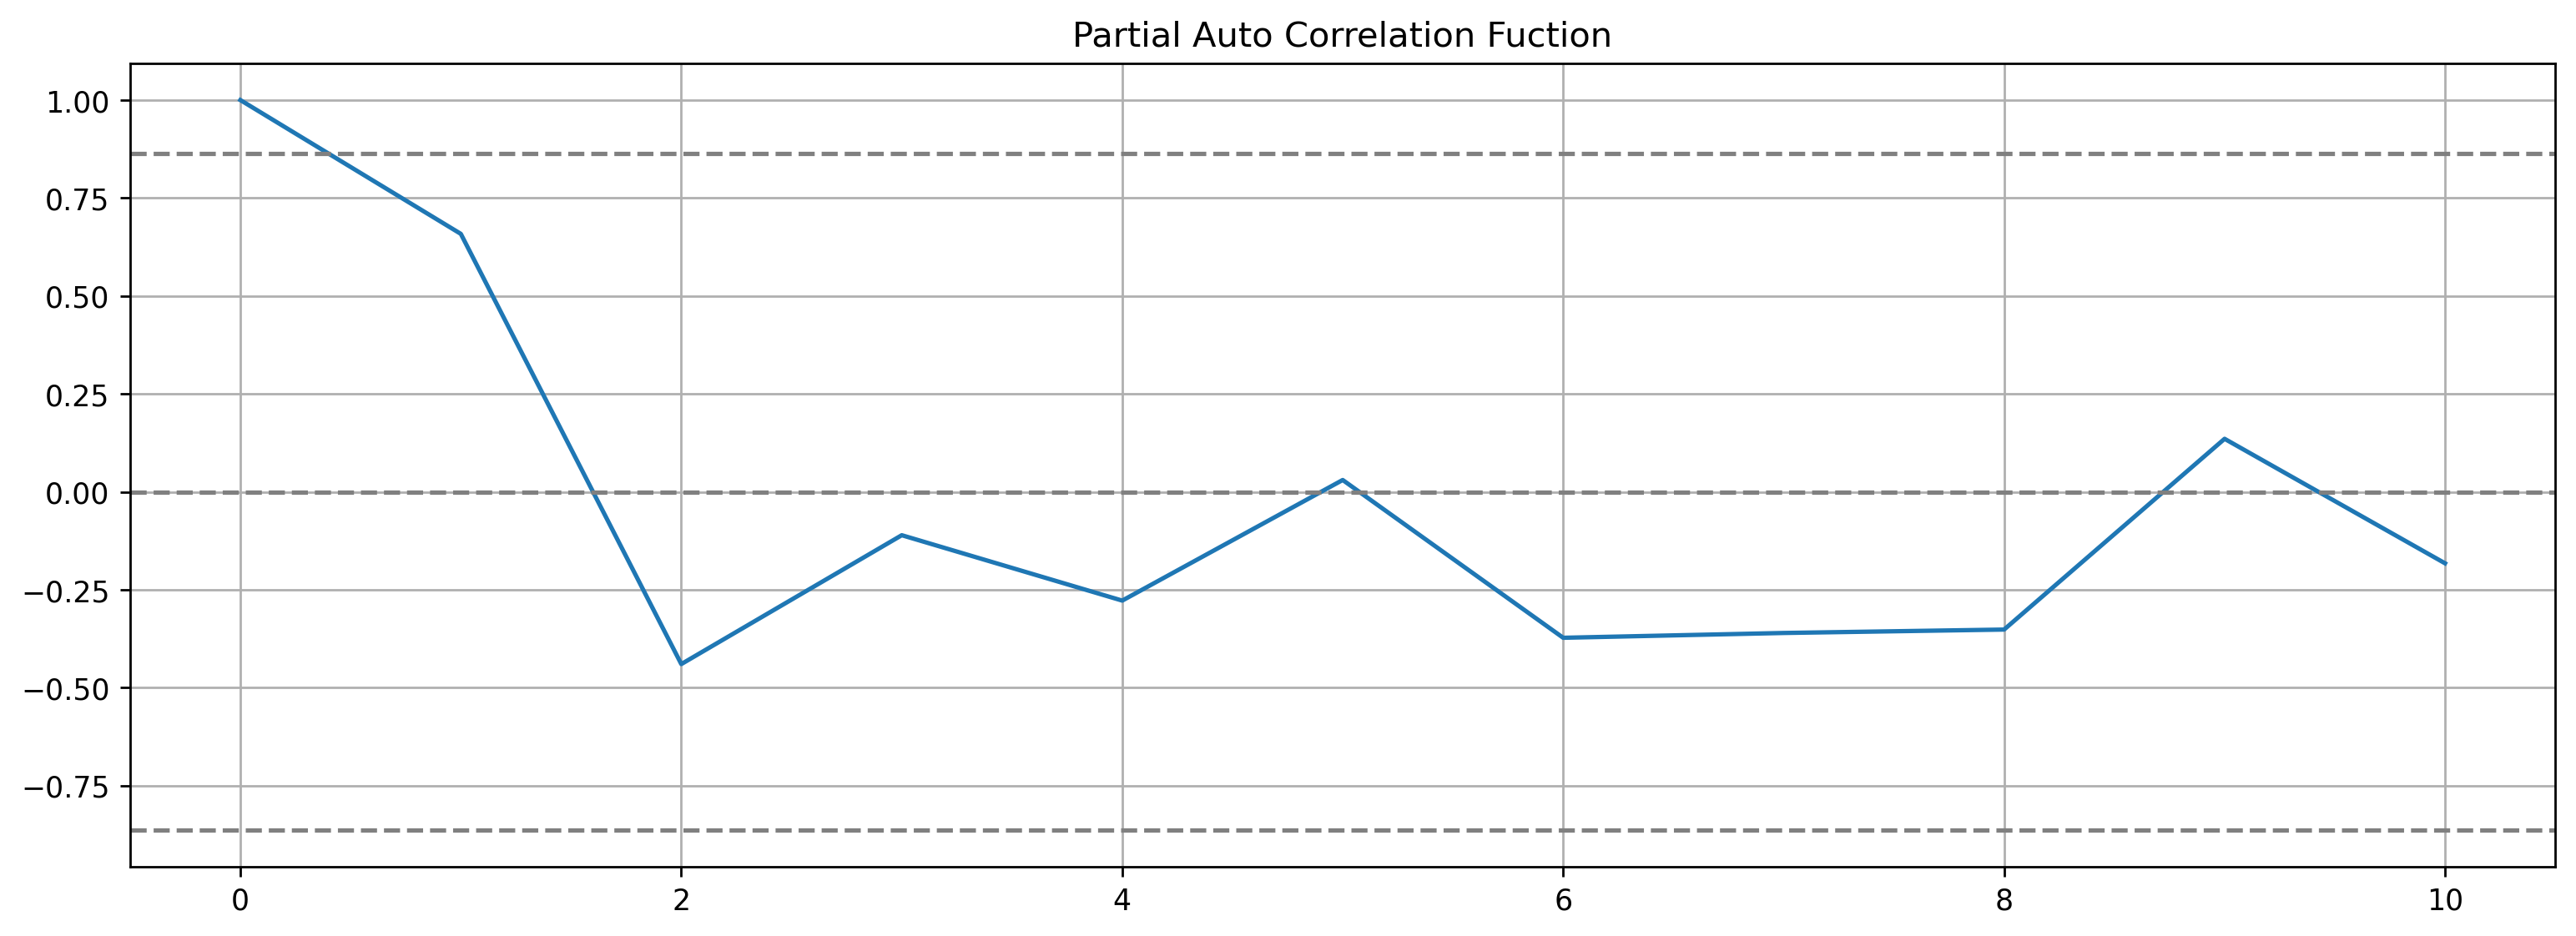

In [47]:
# Partial Auto Correlation Fuction (PACF)

plt.plot(np.arange(pacf(tslma, nlags=10).shape[0]),pacf(tslma, nlags=10))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.title('Partial Auto Correlation Fuction')
plt.grid()
plt.show()

**Model Building :**

In [48]:
# Building ARIMA model
Arima = ARIMA(tslma,order=(1,1,1))
Ar = Arima.fit()

# Summary of ARIMA model
Ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                   85
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  75.512
Date:                Mon, 13 Feb 2023   AIC                           -145.025
Time:                        11:02:32   BIC                           -137.732
Sample:                    12-01-1995   HQIC                          -142.093
                         - 12-01-2002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6213      0.178     -3.498      0.000      -0.969      -0.273
ma.L1          0.8945      0.094      9.524      0.000       0.710       1.079
sigma2         0.0096      0.002      4.590      0.000       0.006       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.58
Prob(Q):                              0.94   Prob(JB):                         0.17
Heteroskedasticity (H):               1.06   Skew:                             0.11
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

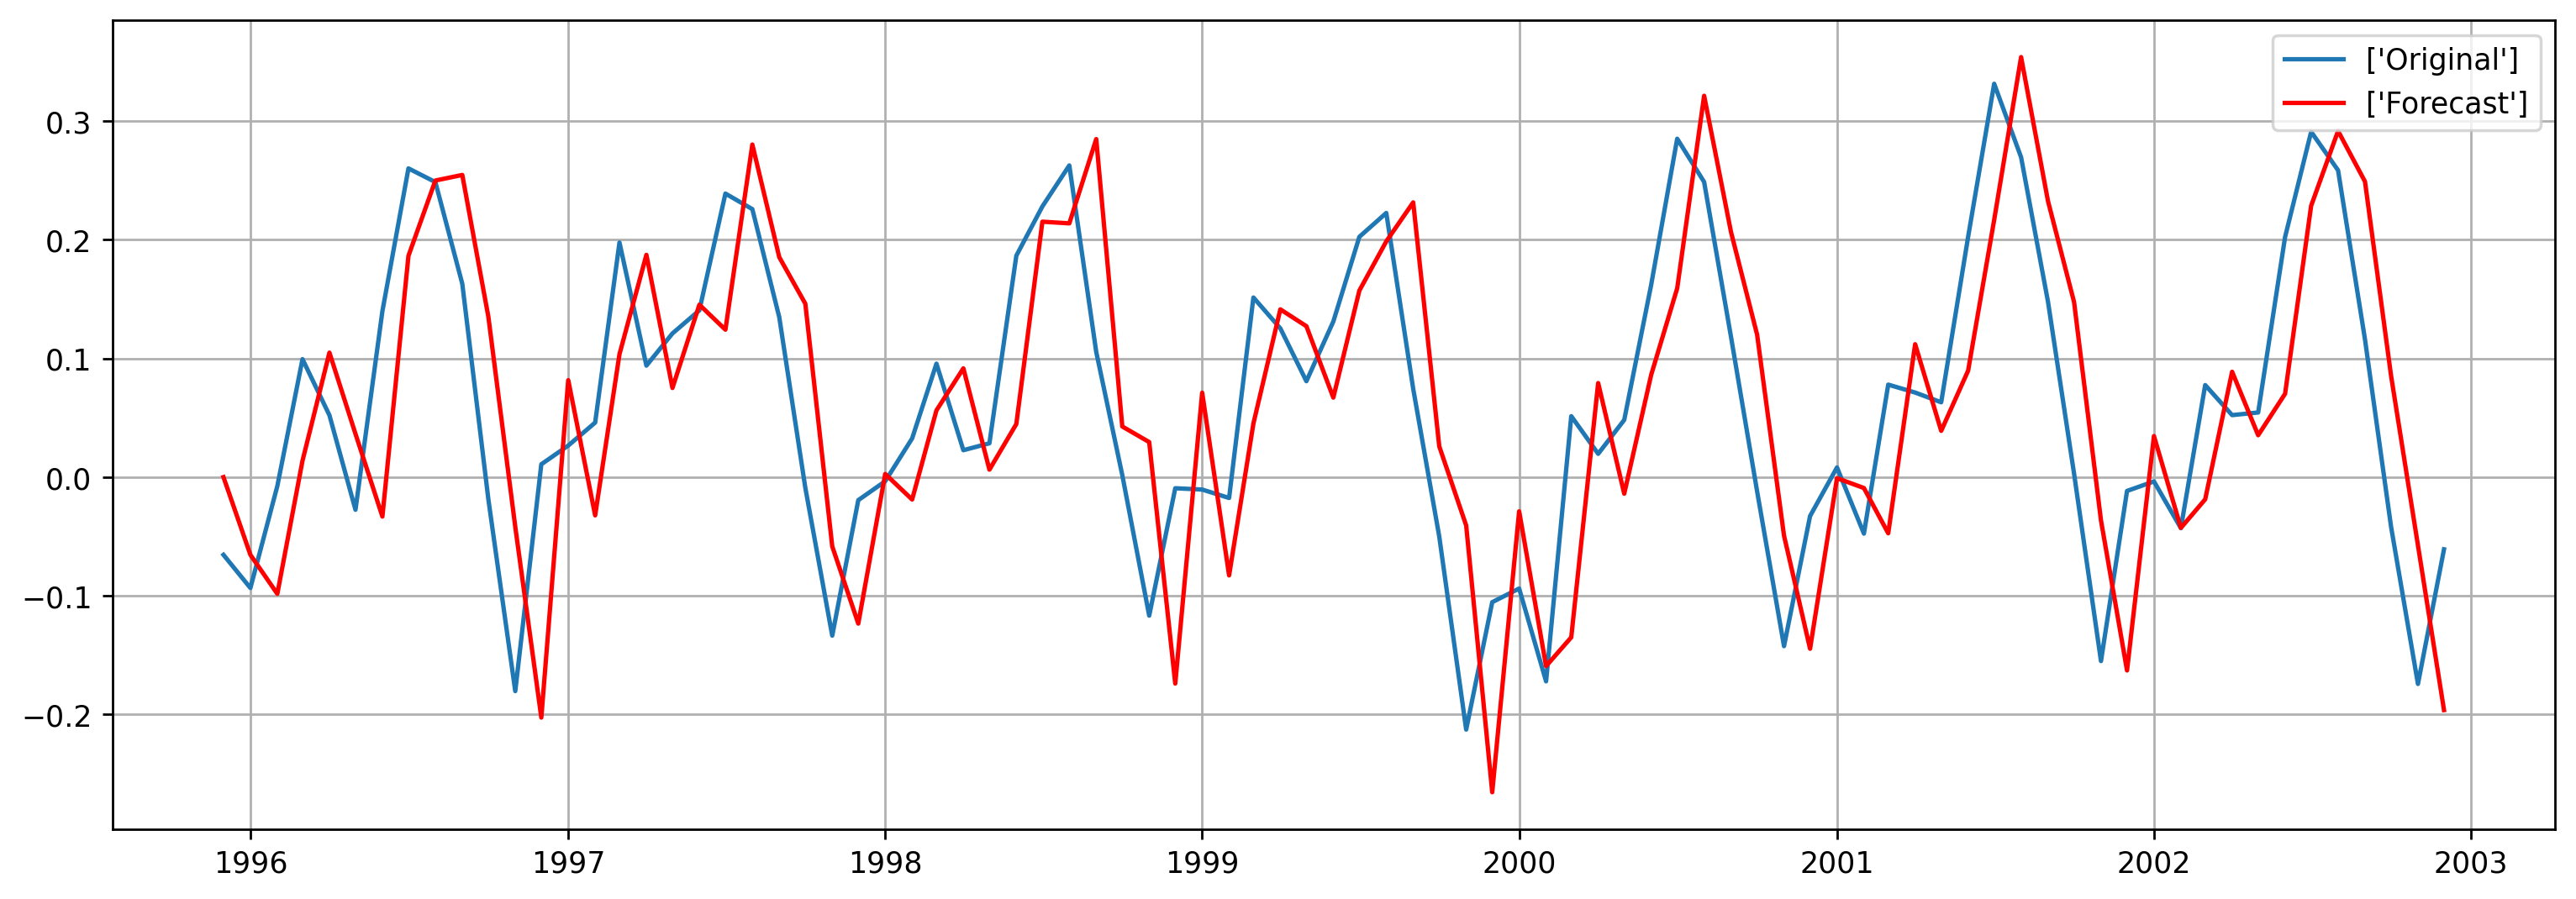

In [49]:
plt.plot(tslma, label=['Original'])
plt.plot(Ar.fittedvalues,c='r', label=['Forecast'])
plt.legend()
plt.grid()

**Forecasting :**

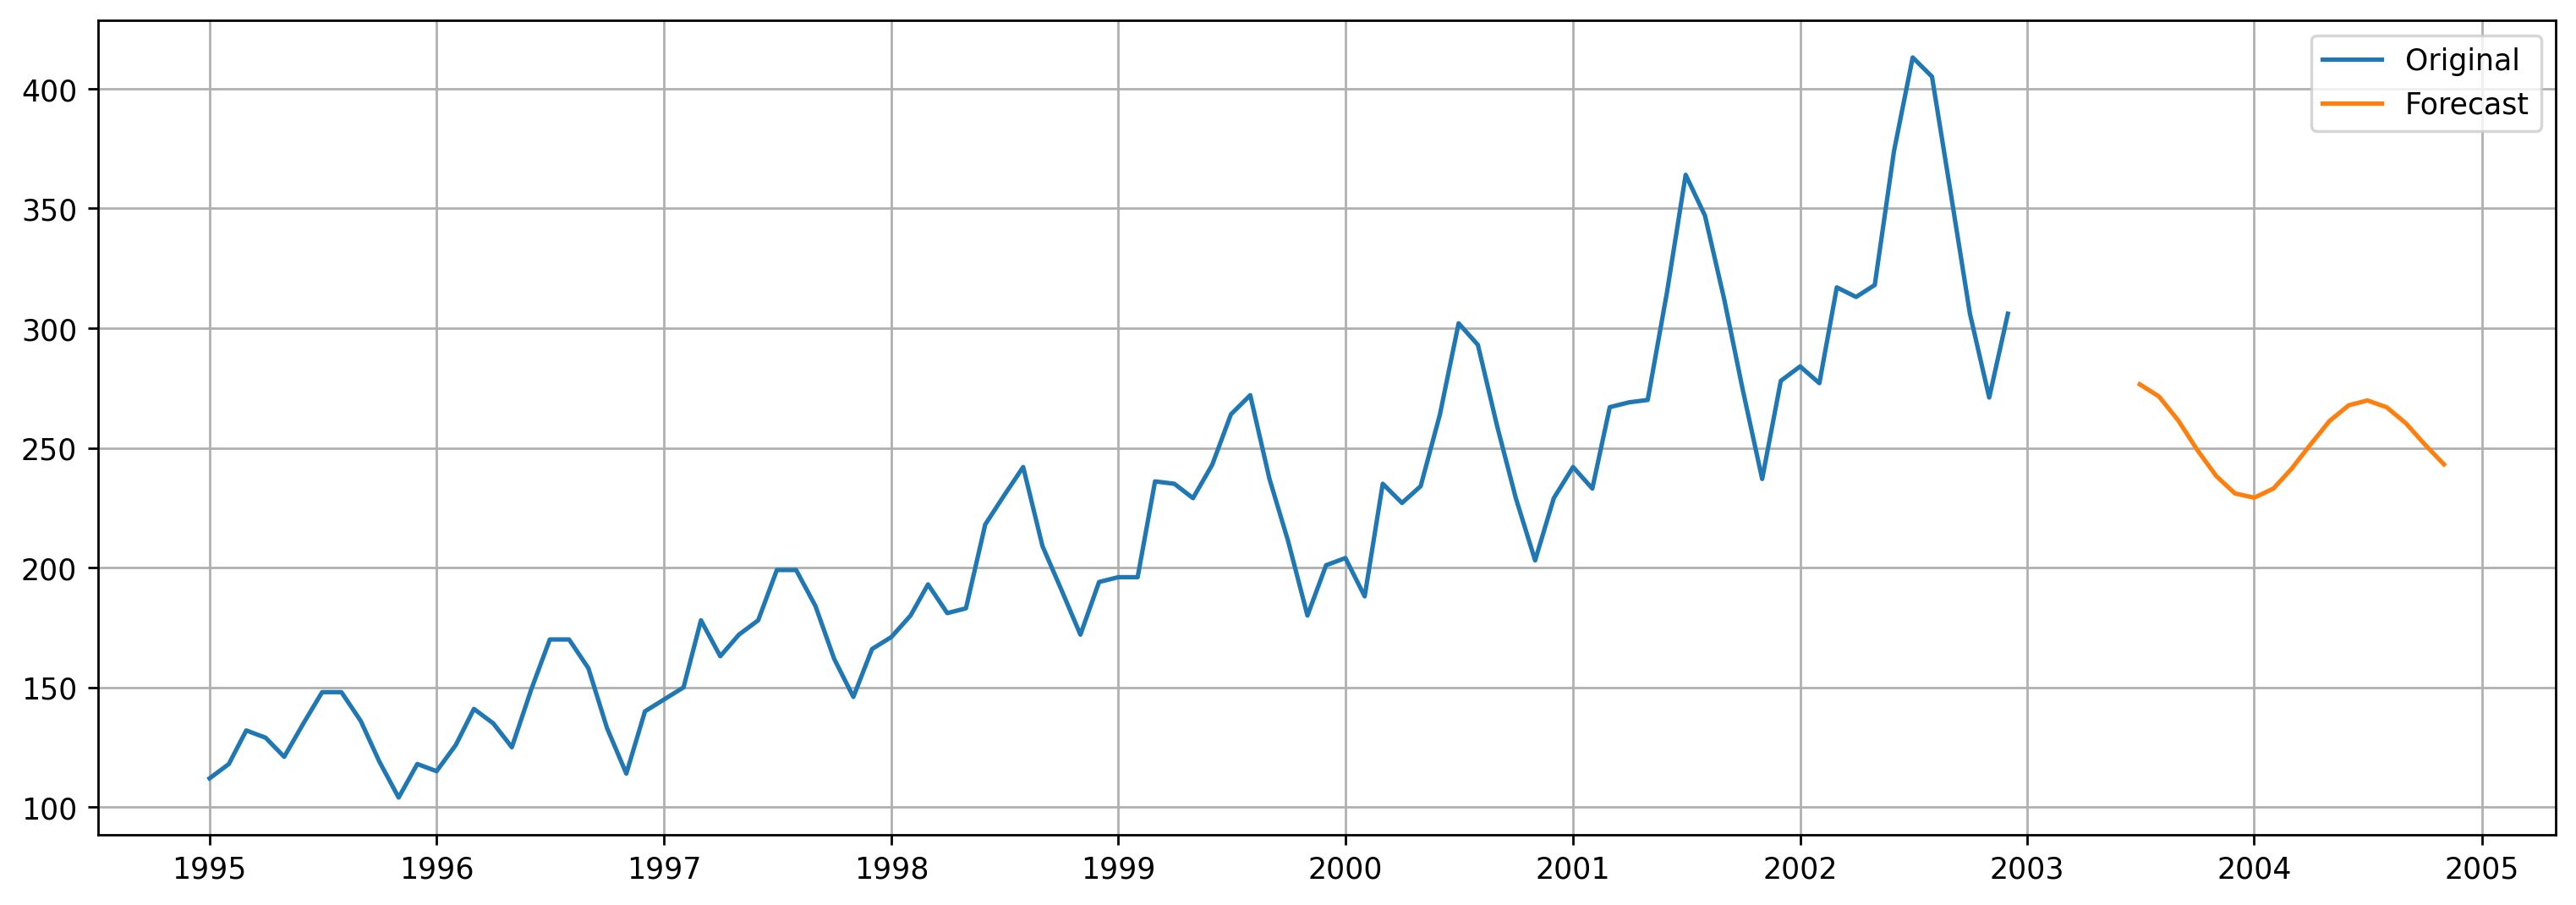

In [52]:
future_dates = [airline.index[-1] + DateOffset(months=x)for x in range(0,24)]
future_datest_df = pd.DataFrame(index=future_dates[1:], columns=airline.columns)

future_datest_df.tail()

future_df = pd.concat([airline, future_datest_df])

future_df['Passengers'] = model_fit.predict(start=102, end=131, dynamic=False)

plt.plot(airline, label='Original')
plt.plot(future_df['Passengers'], label='Forecast')
plt.grid()
plt.legend()
plt.show()